In [2]:
import numpy as np
import pandas as pd 

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

import itertools
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")

### Задание 1.
Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по 1 месяцу.

In [4]:
file_name = 'my_PJME_MW.csv'
data = pd.read_csv(file_name, index_col=[0], parse_dates=[0]).sort_index()
print(data.shape)
data.head(2)

(145374, 13)


,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0


In [5]:
TARGET_NAME = 'PJME_MW'

### 1. EDA

In [6]:
def plot_target(data, title_str, stat=True):
    if stat:
        DF_ct = sm.tsa.stattools.adfuller(data[TARGET_NAME].fillna(0).values, regression='ct')
        DF_ctt = sm.tsa.stattools.adfuller(data[TARGET_NAME].fillna(0).values, regression='ctt')
        print(f'Augmented Dickey–Fuller тест: {round(DF_ct[1], 3)}, {round(DF_ctt[1], 3)}') 
        
    (title, name_1) = title_str
    plt.figure(figsize =(20, 4))
    plt.plot( data.index, data[TARGET_NAME], 'b' )
    plt.title(title, size=14)
    plt.xlabel('Время')
    plt.ylabel(name_1)
    plt.show()

In [7]:
def first_diff(data, title_str, lag=1):
    data_diff = data.copy()    
    data_diff.loc[lag:, TARGET_NAME] = data[TARGET_NAME].values[lag:]-data[TARGET_NAME].values[:-lag]
    plot_target(data_diff[1:], title_str) 

Augmented Dickey–Fuller тест: 0.266, 0.525


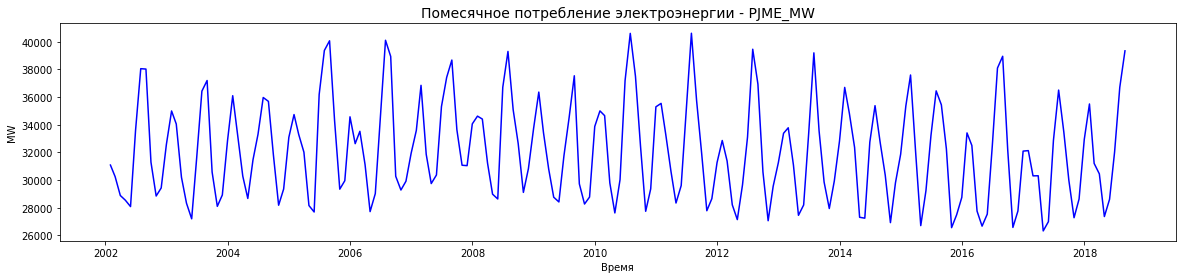

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-31,31075.399731,2002.0,1.0,16.020188,1.0,16.020188,2.873486,2.905787,11.515478,0.063257,0.032301,0.064603
2002-02-28,30239.166667,2002.0,2.0,14.500000,1.0,45.500000,7.071429,3.000000,11.500000,0.035714,0.035714,0.035714


In [8]:
data_m = data.resample('M').mean()
title_str = 'Помесячное потребление электроэнергии - PJME_MW', 'MW'
plot_target(data_m, title_str)
data_m.head(2)

Augmented Dickey–Fuller тест: 0.0, 0.0


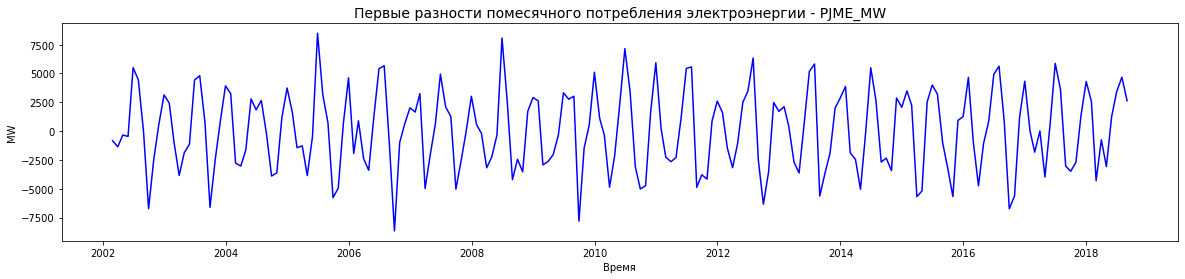

In [9]:
title_str = 'Первые разности помесячного потребления электроэнергии - PJME_MW', 'MW'
first_diff(data_m, title_str)

### Задание 2.
Подберите параметры модели SARIMAX для этого ряда.

In [10]:
n = 12
model = ARIMA(data_m[TARGET_NAME][:-n], order=(2, 1, 2))
model_fitted = model.fit(disp=False)

y_pred = model_fitted.predict(len(data_m[:-n]), len(data_m[:-n]), typ='levels')
y_forecast = model_fitted.forecast(n * 2)

mean absolute percentage error: 3.9%


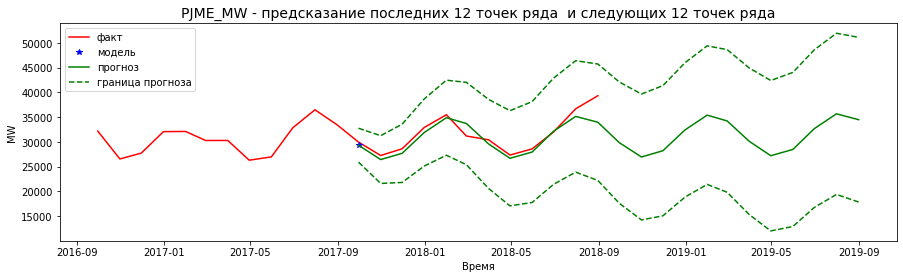

In [11]:
y_true = data_m.iloc[-n:, 0].values
err = np.mean(np.abs((y_true - y_forecast[0][:n]) / y_true)) * 100
print(f'mean absolute percentage error: {round(err, 2)}%')

plt.figure( figsize=(15, 4))
plt.plot(data_m.iloc[-2 * n:, 0],'r', label ='факт')
plt.plot(y_pred, '*b', label ='модель')

ind_f = pd.date_range(data_m.index[-n], periods=n * 2, freq="M")
plt.plot(ind_f, y_forecast[0],'g',label ='прогноз')
plt.plot(ind_f, y_forecast[2][:,1],'--g', label = 'граница прогноза')
plt.plot(ind_f, y_forecast[2][:,0],'--g')

plt.xlabel('Время')
plt.ylabel('MW')
plt.title(f'{TARGET_NAME} - предсказание последних {n} точек ряда  и следующих {n} точек ряда', size=14)
plt.legend()
plt.show()

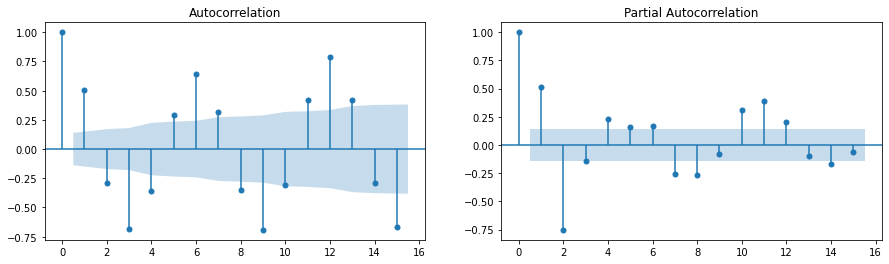

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
lag = 15

sm.graphics.tsa.plot_acf(data_m[TARGET_NAME].values, lags=lag, ax=axes[0])
sm.graphics.tsa.plot_pacf(data_m[TARGET_NAME].values, lags=lag, ax=axes[1])
plt.show()

In [13]:
p, d, q = 2, 1, 2
pdq = [p, d, q]

ps, ds, qs = 0, 2, 2
s = 12
seasonal_pdq = [ps, ds, qs, s] 

print(f'SARIMAX: p, d, q = {pdq},\n\t ps, ds, qs, n = {seasonal_pdq}')

SARIMAX: p, d, q = [2, 1, 2],
	 ps, ds, qs, n = [0, 2, 2, 12]


In [14]:
model = sm.tsa.statespace.SARIMAX(data_m[TARGET_NAME].values[:-n], 
                                  order=pdq,
                                  seasonal_order=seasonal_pdq,
                                  enforce_stationarity= False,
                                  enforce_invertibility=False)

model_fitted = model.fit()

print(f'SARIMAX{pdq}x{seasonal_pdq} - AIC: {round(model_fitted.aic, 2)}')

SARIMAX[2, 1, 2]x[0, 2, 2, 12] - AIC: 2501.11


In [15]:
print(model_fitted.summary().tables[0], model_fitted.summary().tables[1])

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  188
Model:             SARIMAX(2, 1, 2)x(0, 2, 2, 12)   Log Likelihood               -1243.554
Date:                            Mon, 09 Nov 2020   AIC                           2501.109
Time:                                    23:44:02   BIC                           2521.497
Sample:                                         0   HQIC                          2509.394
                                            - 188                                         
Covariance Type:                              opg                                         
========================================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

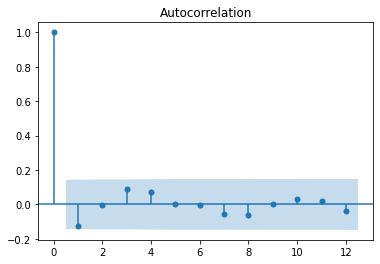

In [16]:
sm.graphics.tsa.plot_acf(model_fitted.resid, lags=s)
plt.show()

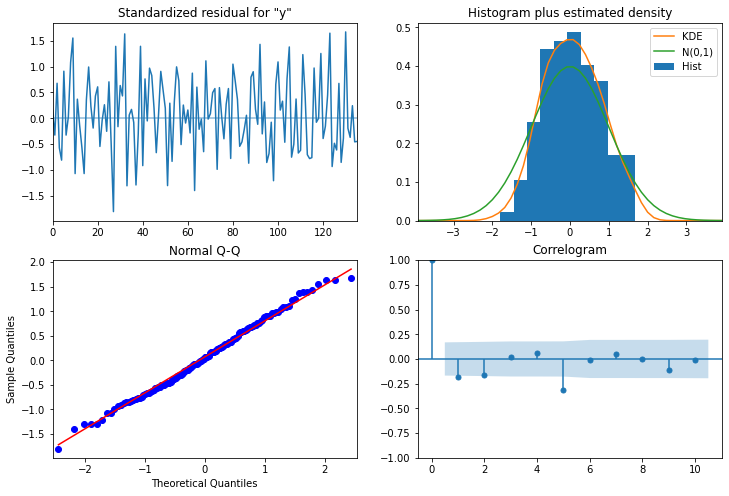

In [17]:
model_fitted.plot_diagnostics(figsize=(12, 8))
plt.show()

Вполне похоже на нормальное распределение

In [18]:
# Определим p, d и q в диапазоне 0-3
p = d = q = range(3)
# зададим сетку p, d и q
pdq = list(itertools.product(p, d, q))

# зададим сезонность p, d и q
p = [0, 1] 
d = [1, 2]
q = [1, 2]
seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(itertools.product(p, d, q))]

In [19]:
min_aic = 2500
for params in pdq:
    for params_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(data_m[TARGET_NAME].values[:-n],
                                              order=params,
                                              seasonal_order=params_seasonal,
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)
            model_fitted = model.fit()
            if model_fitted.aic < min_aic:
                print(f'SARIMAX{params}x{params_seasonal} - AIC:{round(model_fitted.aic, 2)}')
                min_aic = model_fitted.aic
        except:
            continue

SARIMAX(0, 1, 1)x(1, 2, 2, 12) - AIC:2471.11
SARIMAX(0, 1, 2)x(0, 2, 2, 12) - AIC:2442.23
SARIMAX(0, 1, 2)x(1, 2, 2, 12) - AIC:2442.08
SARIMAX(1, 1, 2)x(1, 2, 2, 12) - AIC:2438.81


Модель с лучшими параметрами

In [21]:
model_s = sm.tsa.statespace.SARIMAX(data_m[TARGET_NAME].values[:-n],
                                    order=[0, 1, 1],
                                    seasonal_order=[1, 2, 2, 12],
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
model_fitted = model_s.fit()
y_forecast = model_fitted.forecast(n * 2)
print(f'AIC: {round(model_fitted.aic, 2)}')

y_true = data_m.iloc[-n:, 0].values
err = np.mean(np.abs((y_true - y_forecast[:12]) / y_true)) * 100
print(f'mean absolute percentage error: {round(err, 2)}%')

AIC: 2471.11
mean absolute percentage error: 5.19%


SARIMAX - 5.19%, ARIMA - 3.9%.

In [20]:
model_fitted.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.5653,0.168,3.361,0.001,0.236,0.895
ar.L2,0.2834,0.160,1.773,0.076,-0.030,0.597
ma.L1,-2.0090,0.078,-25.863,0.000,-2.161,-1.857
ma.L2,1.0182,0.079,12.893,0.000,0.863,1.173
ar.S.L12,-0.6965,0.199,-3.508,0.000,-1.086,-0.307
ma.S.L12,-0.7089,0.257,-2.758,0.006,-1.213,-0.205
ma.S.L24,-0.1629,0.248,-0.656,0.512,-0.649,0.324
sigma2,8.382e+06,8.1e-09,1.04e+15,0.000,8.38e+06,8.38e+06


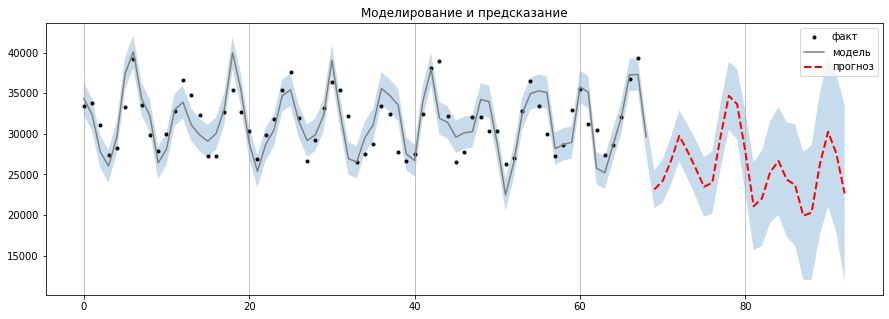

In [21]:
t = 120  # отступ данных для отображения  модели (для улучшения визуальных качеств рисунка)
nforecast = n * 2  # общее число точек для предсказания (N2 - тестовых точек + точки для чистого предсказания)
predict_ = model_fitted.get_prediction(end=model_fitted.nobs + nforecast)  

idx = np.arange(len(predict_.predicted_mean)-t)
predict_ci = predict_.conf_int(alpha=0.5)

fig, ax = plt.subplots(figsize=(15, 5))
ax.xaxis.grid()

ax.plot(data_m[TARGET_NAME].values[t+n:], 'k.', label='факт')

ax.plot(idx[:-nforecast], predict_.predicted_mean[t:-nforecast], 'gray',label = 'модель')
ax.plot(idx[-nforecast:], predict_.predicted_mean[-nforecast:], 'r--', linestyle='--', linewidth=2, label='прогноз')
ax.fill_between(idx, predict_ci[t:, 0], predict_ci[t:, 1], alpha=0.25)
plt.legend()
ax.set(title='Моделирование и предсказание');

### Задание 3.
Сделайте вывод о том, как изменилась модель по сравнению с недельной.

На среднемесячных данных AIC 2438.81, на недельных 7316.40

### Задание 4
Постройте ACF, PACF и модель ARIMA для BRENT (недельный)

In [22]:
file_name = 'my_BRENT2019.csv'
data = pd.read_csv(file_name, index_col=[0], parse_dates=[0]).sort_index()
print(data.shape)
data.head(2)

(2667, 11)


,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0


In [23]:
TARGET_NAME = 'Значение'

Augmented Dickey–Fuller тест: 0.331, 0.32


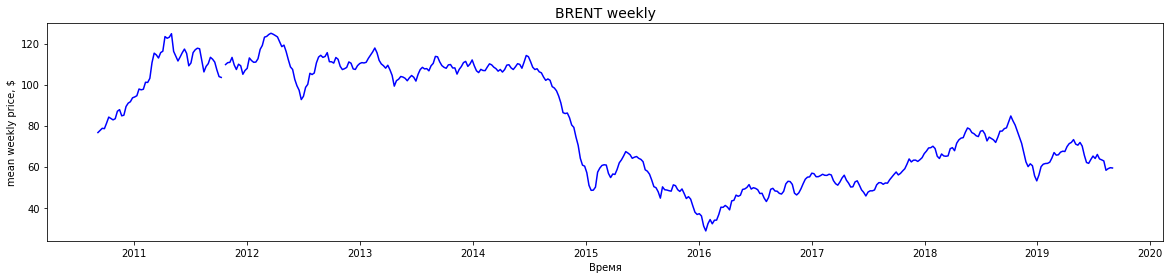

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-05,76.616000,2010.0,9.0,3.0,3.0,246.0,35.0,4.0,0.000000,0.2,0.000000
2010-09-12,77.673333,2010.0,9.0,8.5,3.0,251.5,36.0,2.5,0.166667,0.0,0.166667


In [24]:
data_w = data.resample('W').mean()
title_str = 'BRENT weekly', 'mean weekly price, $'
plot_target(data_w, title_str)
data_w.head(2)

Augmented Dickey–Fuller тест: 0.0, 0.0


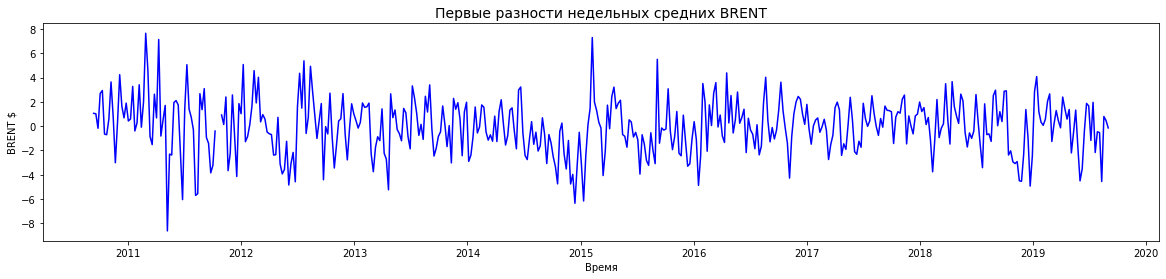

In [25]:
title_str = 'Первые разности недельных средних BRENT', 'BRENT $'
first_diff(data_w, title_str, lag=1)

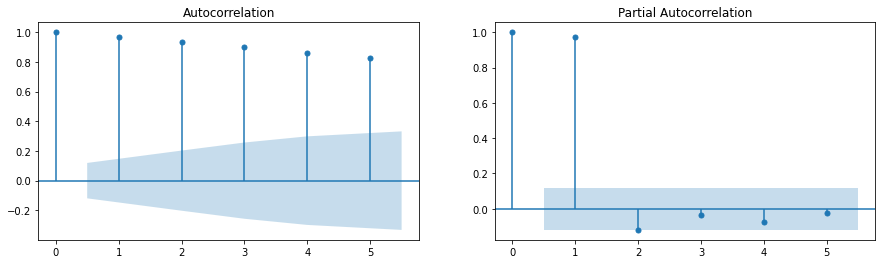

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
lag = 5
t = 200
sm.graphics.tsa.plot_acf(data_w[TARGET_NAME][t:].values, lags=lag, ax=axes[0])
sm.graphics.tsa.plot_pacf(data_w[TARGET_NAME][t:].values, lags=lag, ax=axes[1])
plt.show()

In [27]:
n = 12
model = ARIMA(data_w[TARGET_NAME][t:-n], order=(0, 1, 0))
model_fitted = model.fit(disp=False)

y_pred = model_fitted.predict(len(data_w[t:-n]), len(data_w[t:-n]), typ='levels')
y_forecast = model_fitted.forecast(n * 2)

mean absolute percentage error: 3.31%


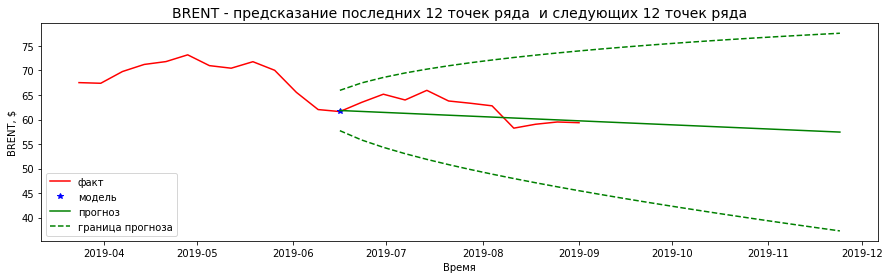

In [28]:
y_true = data_w.iloc[-n:, 0].values
err = np.mean(np.abs((y_true - y_forecast[0][:n]) / y_true)) * 100
print(f'mean absolute percentage error: {round(err, 2)}%')

plt.figure( figsize=(15, 4))
plt.plot(data_w.iloc[-2 * n:, 0],'r', label ='факт')
plt.plot(y_pred, '*b', label ='модель')

ind_f = pd.date_range(data_w.index[-n], periods=n * 2, freq="W")
plt.plot(ind_f, y_forecast[0],'g',label ='прогноз')
plt.plot(ind_f, y_forecast[2][:,1],'--g', label = 'граница прогноза')
plt.plot(ind_f, y_forecast[2][:,0],'--g')

plt.xlabel('Время')
plt.ylabel('BRENT, $')
plt.title(f'BRENT - предсказание последних {n} точек ряда  и следующих {n} точек ряда', size=14)
plt.legend()
plt.show()

### Задание 5
Оцените результат моделирования

Mean absolute percentage error всего 3.31%.

### Задание 6
Сделайте предположение о моделях, которые лучше работают с техниками регрессии на основе ARIMA.

Техники регрессии лучше работают с моделями, где в данных, видимо, есть сильные коррелирующие связи, которые можно "обернуть" в функцию.